This notebook aims to conduct data-preprocessing steps for our PD Model, specific to machine learning. The following will be conducted. 
- Outlier / Skewness Detection & Treatment 
- Feature Selection (WoE & IV)
- Feature Engineering / Creation 
- Multicollinearity Handling 
- Master Table for PD Production 

# 0. Import Libraries 

new order is outlier handling continuous raw data -> deal with them -> feature engineering (interaction features) (they are to be binned anyway) -> then feature selection via WoE and IV -> multicollinearity check + low variance check? 


In [1]:
# Import function to start Spark
from init_spark import start_spark
spark = start_spark()

from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum 
)

from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/13 15:14:07 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/07/13 15:14:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-23762ffa-b3d4-4ed2-9776-c9317cb9c069;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


In [2]:

# Check if Gold Delta is accessible for subsequent model building 
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data_b4_model")
    
df.limit(10).toPandas()

25/07/13 15:14:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,44107057,11500.0,11500.0,60,18.25,293.60,E,RENT,25000.00,Verified,...,0.0,2.0,100.0,20.0,0.0,0.0,24200.0,10307.0,16300.0,0.0
1,47038475,12000.0,12000.0,36,6.92,370.09,A,RENT,53900.00,Verified,...,0.0,5.0,100.0,0.0,0.0,0.0,212844.0,79756.0,89700.0,36144.0
2,44613469,32000.0,32000.0,60,13.99,744.42,C,MORTGAGE,88000.00,Verified,...,0.0,1.0,80.0,100.0,0.0,0.0,36700.0,25736.0,17000.0,0.0
3,43570106,17000.0,17000.0,60,10.99,369.54,B,MORTGAGE,49378.80,Verified,...,0.0,2.0,100.0,100.0,0.0,0.0,193352.0,34738.0,16800.0,21052.0
4,44986522,4375.0,4375.0,36,16.55,155.01,D,MORTGAGE,48180.00,Source Verified,...,0.0,3.0,71.0,66.7,1.0,0.0,19824.0,4318.0,3750.0,15374.0
5,44756975,1000.0,1000.0,36,9.99,32.27,B,MORTGAGE,62560.00,Verified,...,0.0,1.0,100.0,100.0,0.0,0.0,272967.0,25369.0,14200.0,33267.0
6,43370547,6300.0,6300.0,36,12.29,210.13,C,RENT,58000.00,Source Verified,...,0.0,9.0,83.0,40.0,0.0,1.0,17650.0,8586.0,8450.0,0.0
7,44956266,7000.0,7000.0,36,6.92,215.89,A,RENT,42722.05,Verified,...,0.0,1.0,93.7,0.0,1.0,0.0,34004.0,14724.0,20300.0,12999.0
8,44723575,6000.0,6000.0,36,13.99,205.04,C,RENT,41940.00,Verified,...,0.0,3.0,67.9,33.3,0.0,0.0,30923.0,20795.0,5500.0,14623.0
9,46673650,14900.0,14900.0,36,14.65,513.97,C,MORTGAGE,65000.00,Verified,...,0.0,0.0,87.5,50.0,0.0,0.0,208084.0,25978.0,5500.0,26309.0


# 1. Outlier & Skewness Detection & Treatment 


### 1.0 Mitigate Data Leak 
In credit risk modeling, there are normally features in the dataset, which 'tells our model' the answer, when it should not. Put simply, these are features that hint to the model that the borrower has defaulted in the corresponding record. This is termed as 'data leak' in the data realm and should not happen, since machine learning models are meant to predict the future, using past data. Similarly, we are trying to utilise features known at the time of loan origination, to predict a borrower's / loan's probability of default. As such, let's drop such features right from the start which aren't useful for PD Modeling. An example would be how `grade` is assigned to a loan, after Lending Club has evaluated a borrower's fico score, income, dti etc. 

In [3]:
post_loan_origination_features = ['grade', 'int_rate', 'funded_amnt', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt']
df = df.drop(*post_loan_origination_features) # Final Loan Balaance ? 
print('✅ Post Loan Origination Features Dropped ...')

✅ Post Loan Origination Features Dropped ...


### 1.1 Outlier & Skewness Detection 

Before feature engineering, we will be dealing with outliers and skewed distributions, which can distort credit risk models. They can dominate learning, causing bias or overfitting in our PD Model. Let's first identify features which are highly skewed. 

#### 1.1.1 Columns with Outliers 
Upon identifying highly skewed variables in our dataset, it seems we have some absurdly skewed variables. To investigate further, we will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers of these columns. We will be using the IQR method in detecting outliers. 

In [4]:
def compute_outlier_pct(df, col_name, lower_pct=0.25, upper_pct=0.75):
    '''Computes pct of outliers per column based on IQR method '''
    
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return round(df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100, 2) 

# 1. After cleaning missing values, find % outliers per column (sampling big data for efficiency)
sample_df = df.select([feature.name for feature in df.schema if isinstance(feature.dataType, NumericType)]).sample(fraction=0.05, seed=42) 


outliers_dict = {}

for feature in sample_df.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = compute_outlier_pct(sample_df, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct


print('❌ Outlier Percentage by Feature (sorted):')
for k, v in sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {round(v, 2)}%")


❌ Outlier Percentage by Feature (sorted):
num_accts_ever_120_pd: 22.31%
delinq_2yrs: 18.57%
pub_rec: 15.96%
default_status: 12.2%
pub_rec_bankruptcies: 12.14%
mths_since_recent_bc: 9.21%
bc_open_to_buy: 9.19%
mo_sin_rcnt_rev_tl_op: 8.37%
pct_tl_nvr_dlq: 7.17%
mo_sin_rcnt_tl: 6.7%
total_bc_limit: 6.44%
total_rev_hi_lim: 6.43%
revol_bal: 6.38%
total_bal_ex_mort: 6.29%
avg_cur_bal: 6.08%
mo_sin_old_il_acct: 5.73%
total_il_high_credit_limit: 5.67%
mths_since_recent_inq: 5.28%
num_tl_90g_dpd_24m: 5.18%
annual_inc: 4.9%
num_bc_sats: 4.65%
num_il_tl: 4.45%
last_fico_range_high: 4.35%
last_fico_range_low: 4.35%
num_op_rev_tl: 4.19%
tot_cur_bal: 4.1%
inq_last_6mths: 4.08%
mort_acc: 4.07%
tot_hi_cred_lim: 3.89%
open_acc: 3.62%
mo_sin_old_rev_tl_op: 3.55%
num_sats: 3.54%
fico_range_low: 3.37%
fico_range_high: 3.37%
installment: 3.34%
tax_liens: 2.87%
num_actv_rev_tl: 2.77%
num_tl_op_past_12m: 2.51%
num_rev_tl_bal_gt_0: 2.5%
num_rev_accts: 2.49%
num_bc_tl: 2.31%
num_actv_bc_tl: 2.24%
acc_open_past

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

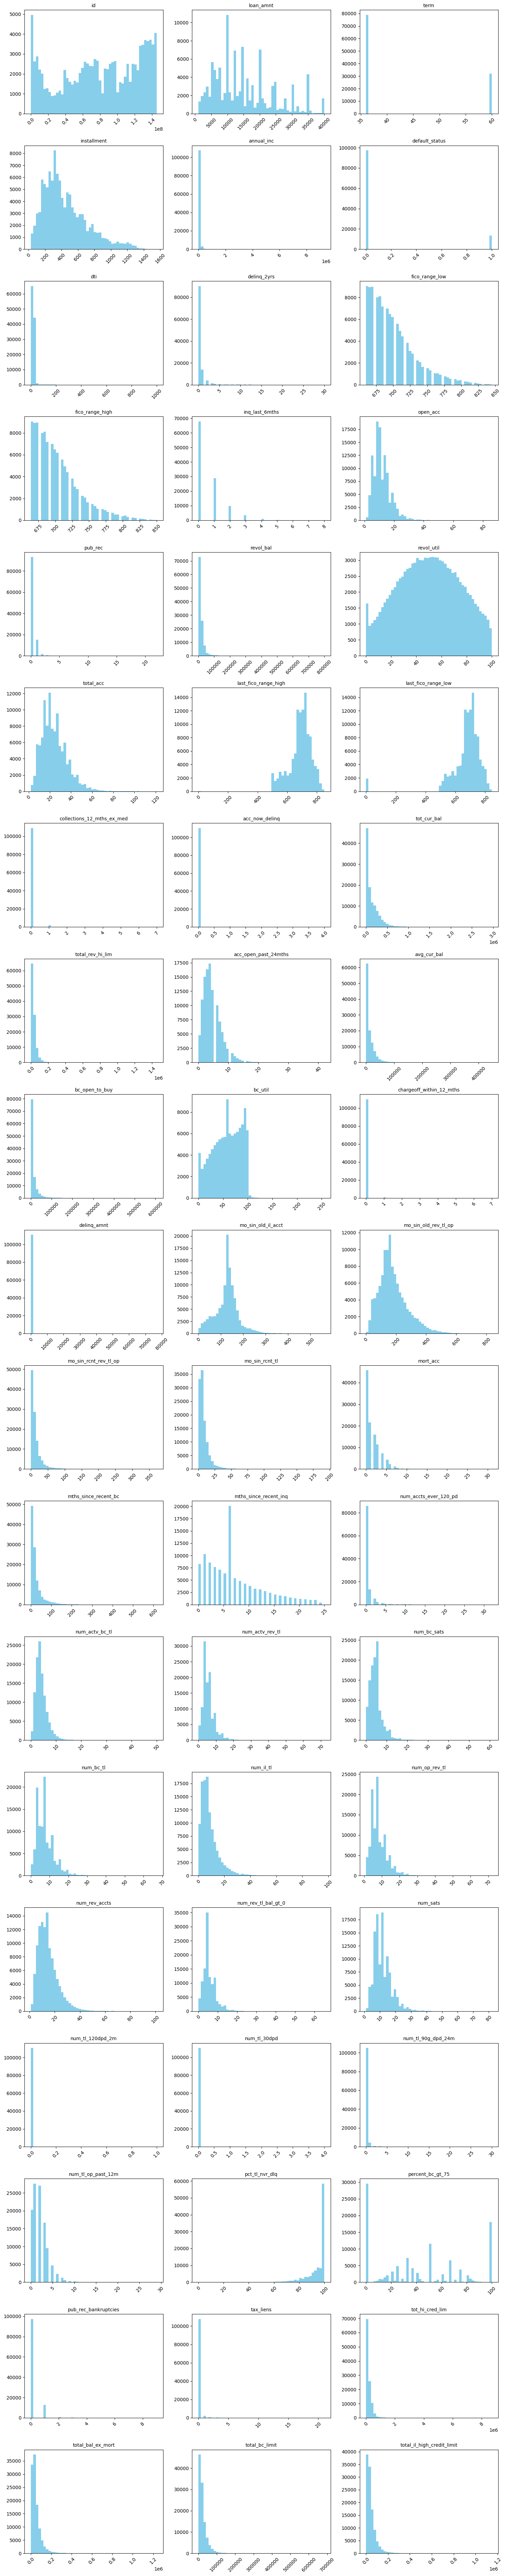

In [5]:
# 5. Check INITIAL DISTRIBUTION OF NUMERICAL FEATURES 

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

def display_distributions(df): 

    # 1. Select numerical columns
    numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

    # 2. Sample small portion of data (e.g., 5%) and convert to pandas
    sample_df = df.select(numeric_cols).sample(fraction=0.05, seed=42)
    sample_pdf = sample_df.toPandas()

    # 3. Plot histograms as subplots
    n_cols = 3  # Number of plots per row
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col_name in enumerate(numeric_cols):
        axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
        axes[i].set_title(col_name, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
display_distributions(df)

From the original distribution of our cleaned dataset, we can observe that we have many skewed features, which is common is credit risk datasets. Before dealing with skewness, it is important to handle outliers first. Skewness measures the symmetry of a feature, and a few outliers can over-inflate the skewness of a feature, rendering the skewness value inaccurate. This can lead to us blindly applying transformations to a feature, when it does harm to our PD Model. 

As such, based on the nature of an outlier, they will be dealt in different ways. 
- **Clear Data Error**: Trim 
- **Real Outlier but Rare (Domain Knowledge Based)**: Winsorise till IQR Bounds 
- **Outlier is Real & Meaningful** : Let WoE binning handle this outlier 

In [6]:
from pyspark.sql import DataFrame
def inspect_outliers_iqr(df: DataFrame, columns: list, sample_size: int = 5):
    for col_name in columns:
        try:
            print(f"\n📊 Inspecting Outliers for Column: `{col_name}`")

            # Step 1: Calculate Q1, Q3, and IQR
            q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            print(f"Q1 = {q1}, Q3 = {q3}, IQR = {iqr}")
            print(f"Lower Bound = {lower}, Upper Bound = {upper}")

            # Step 2: Count outliers
            outlier_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
            total_count = df.count()
            outlier_pct = round(outlier_count / total_count * 100, 2)
            print(f"Outlier Count: {outlier_count} ({outlier_pct}%)")

            # Step 3: Sample outlier values (top and bottom)
            print(f"🔼 Top Outliers (>{upper}):")
            df.filter(col(col_name) > upper).select(col_name).orderBy(col(col_name).desc()).show(sample_size)

            print(f"🔽 Bottom Outliers (<{lower}):")
            df.filter(col(col_name) < lower).select(col_name).orderBy(col(col_name)).show(sample_size)

        except Exception as e:
            print(f"❌ Could not process column `{col_name}`: {str(e)}")

outlier_columns = list(outliers_dict.keys())  # or use your own column list
inspect_outliers_iqr(df, outlier_columns)



📊 Inspecting Outliers for Column: `loan_amnt`
Q1 = 8000.0, Q3 = 20000.0, IQR = 12000.0
Lower Bound = -10000.0, Upper Bound = 38000.0
Outlier Count: 34330 (1.55%)
🔼 Top Outliers (>38000.0):
+---------+
|loan_amnt|
+---------+
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
+---------+
only showing top 5 rows
🔽 Bottom Outliers (<-10000.0):
+---------+
|loan_amnt|
+---------+
+---------+


📊 Inspecting Outliers for Column: `installment`
Q1 = 249.08, Q3 = 593.21, IQR = 344.13
Lower Bound = -267.1149999999999, Upper Bound = 1109.405
Outlier Count: 63832 (2.87%)
🔼 Top Outliers (>1109.405):
+-----------+
|installment|
+-----------+
|    1719.83|
|    1719.83|
|    1717.63|
|    1715.42|
|    1715.42|
+-----------+
only showing top 5 rows
🔽 Bottom Outliers (<-267.1149999999999):
+-----------+
|installment|
+-----------+
+-----------+


📊 Inspecting Outliers for Column: `annual_inc`
Q1 = 46000.0, Q3 = 92000.0, IQR = 46000.0
Lower Bound = -23000.0, Upper Bound = 161000.0
Outlier Cou

From the above, we group features with outliers into the following groups. Reasons why I grouped certain features into a category are as explained. 

Due to the uncertainty of credit risk modelers in the real world, it is often a common practice that they keep their outlier handling methods in an audit-trail such as Excel. They will come back to revisit, should model performance fails to pass the company's set threshold. A similar audit trail will be in `sandbox/model_building_audit_trail.xlsx`.

In [7]:
# Checking for invalid values 

# df.where(col('int_rate') < 0).toPandas()
# df.where(col('installment') < 0).toPandas()
# df.where(col('annual_inc') < 0).toPandas()
# df.where(col('dti') < 0).toPandas()
# df.where(col('delinq_2yrs') > 0).toPandas()
# df.where(col('inq_last_6mths') < 0).toPandas()
# df.select(col('open_acc')).distinct().count()
# df.where(col('pub_rec') > 0).toPandas()
# df.where(col('revol_bal') <0).toPandas()
# df.where(col('total_acc') <0).toPandas()
# df.where(col('last_fico_range_low') < 300).toPandas()
# df.where(col('total_rev_hi_lim') > 83250).toPandas()
# df.where(col('acc_open_past_24mths') < 0).toPandas()
# df.where(col('avg_cur_bal') < 0).toPandas()
# df.where(col('mo_sin_old_rev_tl_op')< 0).toPandas()
# df.where((col('tot_hi_cred_lim')< 9_999_999) & (col('tot_hi_cred_lim') > 200_000)).toPandas()
# df.where((col('tot_hi_cred_lim')< 0)).toPandas()
# df.where((col('total_bc_limit')< 0)).toPandas()

In [8]:
def winsorise_col(df, col_name,operator: str,  condition_val, final_val):
    """
    Winsorises a column by replacing values above a certain condition with a final value.
    
    Args:
        df (DataFrame): The input DataFrame.
        col_name (str): The name of the column to winsorise.
        condition_val (float): The value above which to replace with final_val (cut-off)
        final_val (float): The value to replace with.
        
    Returns:
        DataFrame: The DataFrame with the winsorised column.
    """
    print("✅ Winsorising column:", col_name, "...")
    
    if operator == '<':
        return df.withColumn(col_name, when(col(col_name) < condition_val, final_val).otherwise(col(col_name)))
    
    elif operator == '>':
        return df.withColumn(col_name, when(col(col_name) > condition_val, final_val).otherwise(col(col_name)))

def retain_rows(df: DataFrame, col_name: str, condition_val: float, operator: str) -> DataFrame:
    """
    Retains rows in the DataFrame where the specified column meets a condition.

    Returns:
        DataFrame: The DataFrame with the specified rows dropped.
    """
    
    if operator == '<=':
        return df.filter(col(col_name) <= condition_val)    
    
    elif operator == '<':
        return df.filter(col(col_name) < condition_val)
    
    elif operator == '>':
        return df.filter(col(col_name) > condition_val)
    
    elif operator == '>=':
        return df.filter(col(col_name) >= condition_val)
    
    else:
        raise ValueError("Operator must be '>=' or '<='")


In [9]:
# Individual Outlier Handling
from pyspark.sql import functions as F

# DTI Outlier Handling
df = retain_rows(df, 'dti', 120, '<=')  # Drop rows where dti > 120
df = winsorise_col(df, 'dti','>', 100, 100)  # Winsorise dti > 100 to 100


# Only allow fico_scores between 300 and 850
df = df.filter((col("last_fico_range_high") <= 850) & (col("last_fico_range_high") >= 300))
df = df.filter((col("last_fico_range_low") <= 850) & (col("last_fico_range_low") >= 300))

# total_rev_hi_lim 
df = df.filter(col("total_rev_hi_lim") < 9_999_999.0) # likely placeholders / data error 

# months since oldest installment account opened
df = df.filter(col("mo_sin_old_il_acct") < 999)  # Drop likely placeholders 
df = df.filter(col("mo_sin_old_rev_tl_op") < 999)  # Drop likely placeholders 

# high credit limit 
df = df.filter(col("tot_hi_cred_lim") < 9_999_999.0)  


✅ Winsorising column: dti ...


It seems that each feature still have outliers. However, this is often normal in credit risk datasets, and it will be illogical if we simply drop them simply because we are outliers. Even if they are outliers, certain data points act as a crucial indicator to PD modeling, e.g. extremely high `dti` can signal high probability of default. 

In real life, it seems that credit risk modelers check the WoE and IV of each feature or build their PD models first, before improving on it, and improving their outlier handling methods manually per feature. For now, let's check out the skewness of features in our dataset. 

#### 1.1.2 Identifying Highly Skewed Features

In [10]:
from pyspark.sql.functions import skewness
from pprint import pprint 

numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]


# Compute skewness for each numeric column 
for column in numeric_columns: 
    
    skew_val = df.select(skewness(col(column))).collect()[0][0]
    
    if skew_val is not None and abs(skew_val) >= 1: 
        skew_val = round(skew_val, 2)  # Round to 2 decimal places
        print(f"{column}: {skew_val} 🚩")
        
    else: 
        print(f"{column}: {skew_val}")
        

id: -0.27347520299971634
loan_amnt: 0.7762160804475983
term: 0.9468956579445807
installment: 0.9993678581200869
annual_inc: 498.52 🚩
default_status: 2.52 🚩
dti: 1.09 🚩
delinq_2yrs: 5.91 🚩
fico_range_low: 1.18 🚩
fico_range_high: 1.18 🚩
inq_last_6mths: 1.82 🚩
open_acc: 1.32 🚩
pub_rec: 10.81 🚩
revol_bal: 11.31 🚩
revol_util: -0.016018570285337316
total_acc: 1.0 🚩
last_fico_range_high: -0.6179549127459487
last_fico_range_low: -0.6179981313750252
collections_12_mths_ex_med: 14.14 🚩
acc_now_delinq: 22.89 🚩
tot_cur_bal: 2.95 🚩
total_rev_hi_lim: 6.11 🚩
acc_open_past_24mths: 1.43 🚩
avg_cur_bal: 3.67 🚩
bc_open_to_buy: 3.78 🚩
bc_util: -0.28085757647975373
chargeoff_within_12_mths: 18.22 🚩
delinq_amnt: 103.83 🚩
mo_sin_old_il_acct: 0.34367549926663765
mo_sin_old_rev_tl_op: 1.03 🚩
mo_sin_rcnt_rev_tl_op: 3.62 🚩
mo_sin_rcnt_tl: 4.63 🚩
mort_acc: 1.82 🚩
mths_since_recent_bc: 3.56 🚩
mths_since_recent_inq: 1.02 🚩
num_accts_ever_120_pd: 5.51 🚩
num_actv_bc_tl: 1.53 🚩
num_actv_rev_tl: 1.62 🚩
num_bc_sats: 1.79

#### 1.1.3 Visualising Distributions 

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

Before that, let's obtain some base features from our dataset. 

First, a common derived feature in credit risk is the credit history length of the borrower at the time of loan issuance. Normally, it would be safe to say that loans with borrowers with a longer credit history has a lower probability of default. Hence, this can be taken into account as 1 of the features of the dataset. We can compute this as the difference between `issue_d` and `earliest_cr_line`. 

In [11]:
import pyspark.sql.functions as F  

df = df.withColumn('credit_history_years',    F.months_between(F.col('issue_d'), F.col('earliest_cr_line')) / 12   )

Second, it seems that we have 2 features related to FICO Scores: `fico_range_low` and `fico_range_high`. Upon further research, these features do not represent the lowest and highest scores ever recorded for a borrower, but rather the lower and upper bounds of a small range in which the borrower’s actual FICO score falls. Banks record these due to privacy concerns, through a 5 point window, as shown below. As such, it seems that we just need to average these 2 values, to minimise redundancy and multicollinearity. The same applies for `last_fico_range_high` and `last_fico_range_low`, we shall average them out first, since any multicollinearity will be detected later on anyways.

In [12]:
df = df.withColumn('fico_score',  (col('fico_range_low') + col('fico_range_high')) / 2  )
df = df.drop( col("fico_range_low")   , col('fico_range_high') ) 

# Last Credit Pull FICO Score 
df = df.withColumn('last_fico_score',  (col('last_fico_range_low') + col('last_fico_range_high')) / 2  )
df = df.drop( col("last_fico_range_low")   , col('last_fico_range_high') ) 

Now, lets visualise the distributions of our features. 

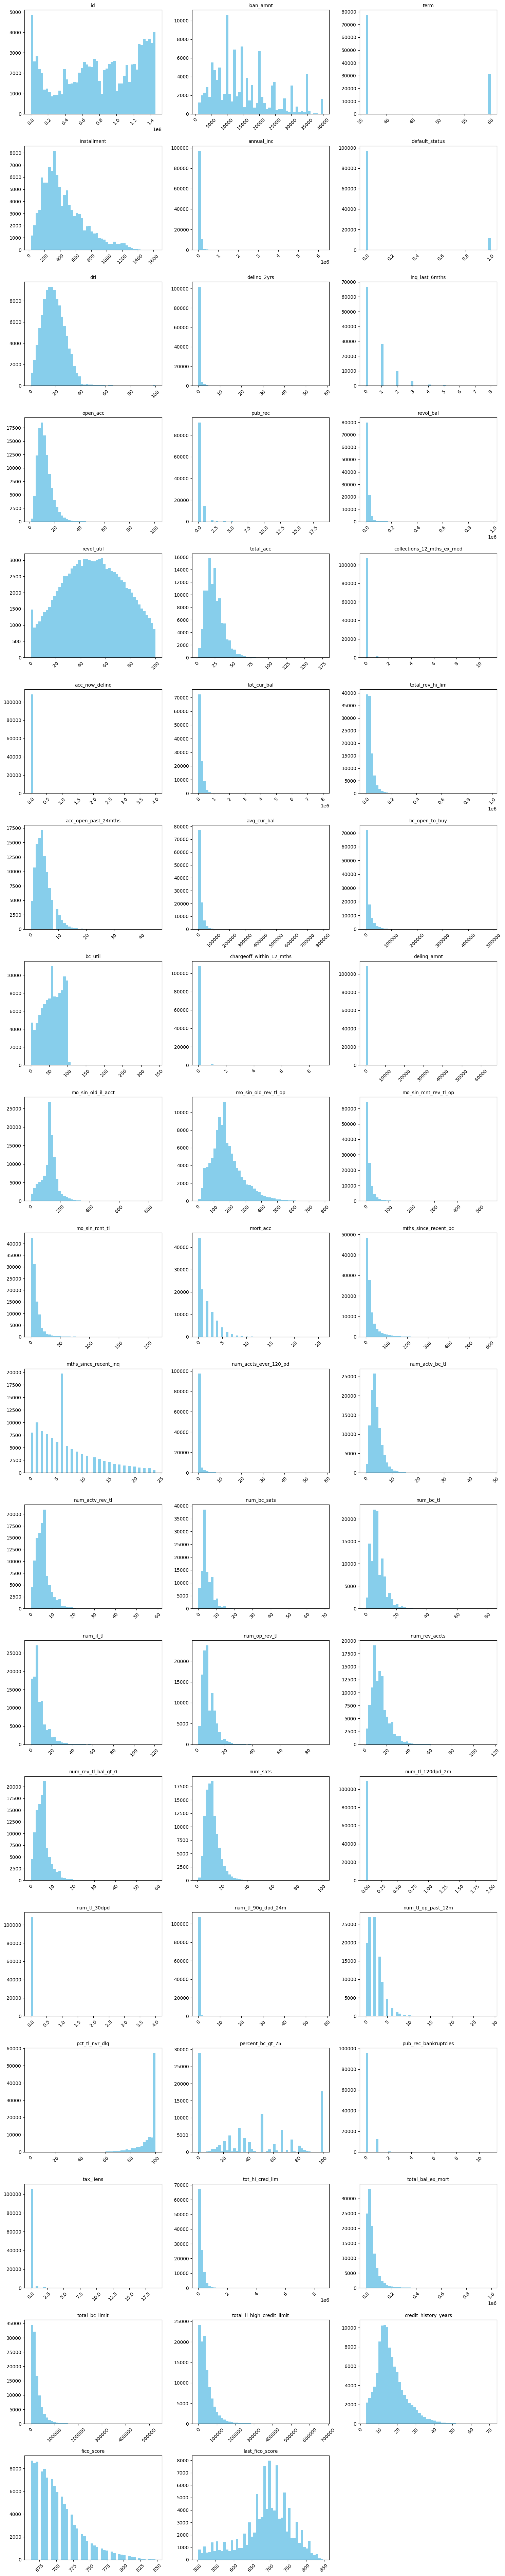

In [13]:
display_distributions(df)


Now, let's deal with skewness issues. We will group the following numerical features into the following categories
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Highly Right Skewed (Continuous Feature)**: Log Transformation, Else Box-Cox 
- **Discrete Variables**: WoE binning in Feature Selection 


⚠️ At this checkpoint, I went on the internet and continued researching about the ideal order of outlier detection -> skewness handling -> WoE & IV Feature Selection. However, I realised that WoE conducts binning of continuous variables and are robust to outliers and skewness. They bin outliers into a separate bin and skewness transformation would not be required. Considering the fact that our outlier handling only dealt with a few features and removed potential placeholders, the code shall not be deleted. Additionally, should the model be instable, skewness shall be looked into in detail later on in the process. 

# 2. WoE & IV Feature Selection

Before feature selection, it is important I understand certain rules I have to adhere to for WoE. 
1) **Monotonicity**: As `feature` bins/values increase, WoE should increase as well. Just like how Logistic Regression Model fits an S-shaped curve, feature and target class should move in the same direction. Else, it violates linearity assumption of Logistic Regression 

2) **No 0 in Good / Bad Counts (Each Bins)**: Required to compute WoE accurately. Prevents division of 0 in WoE calculation 

3) **Group bins of similar WoE together = Coarse binning**

4) **Each bin should have at least 0.5% of good class & bad class**: Drop if unimportant / Merge 

Additionally, I shall follow the following rules for selecting my features for PD Modeling (Logistic Regression). Ideally, I should have ~ 20 features, that are at least 0.05. As I run IV scoring through features, their IV scores shall be recorded to `sandbox/feature_iv_trail.xlsx`

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

In [14]:
# --- 1. Define the target directory ---
import os 
from openpyxl import Workbook


output_dir = "../sandbox/"  # e.g. "/home/username/results"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
output_path = os.path.join(output_dir, "feature_iv_trail.xlsx")

# --- 2. Setup Excel workbook ---
wb = Workbook()
ws = wb.active
ws.title = "IV Scores"
ws.append(["feature", "iv", 'type'])

In [15]:
df.limit(10).toPandas()

,id,loan_amnt,term,installment,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score,last_fico_score
0,137356613,12400.0,36,416.20,OWN,35436.0,Verified,2018-07-01,0,n,...,16.7,0.0,0.0,42000.0,20153.0,37700.0,0.0,5.500000,687.0,727.0
1,136523079,3000.0,36,92.92,RENT,23000.0,Not Verified,2018-07-01,0,n,...,0.0,0.0,0.0,61285.0,8806.0,31000.0,13685.0,10.833333,792.0,797.0
2,137549421,25000.0,36,761.80,MORTGAGE,118927.0,Not Verified,2018-07-01,0,n,...,0.0,0.0,0.0,214500.0,13041.0,26800.0,0.0,33.750000,712.0,722.0
3,135051542,1000.0,36,39.94,RENT,9479.0,Not Verified,2018-07-01,0,n,...,37.5,0.0,0.0,2100.0,408.0,0.0,1500.0,13.666667,682.0,702.0
4,135639525,30000.0,60,894.85,MORTGAGE,81000.0,Verified,2018-07-01,0,n,...,66.7,0.0,0.0,76400.0,54851.0,24900.0,30000.0,36.000000,712.0,667.0
5,136039530,1500.0,36,46.64,RENT,40000.0,Verified,2018-07-01,0,n,...,0.0,0.0,0.0,72544.0,3967.0,47300.0,14444.0,11.500000,787.0,772.0
6,136602296,2600.0,36,88.31,OWN,25000.0,Verified,2018-07-01,0,n,...,0.0,0.0,0.0,88613.0,50525.0,33600.0,52513.0,19.833333,807.0,802.0
7,137216003,20000.0,36,767.44,MORTGAGE,90000.0,Not Verified,2018-07-01,0,n,...,75.0,0.0,0.0,286757.0,28290.0,16400.0,8757.0,15.750000,672.0,617.0
8,136601401,24000.0,60,595.31,MORTGAGE,120000.0,Not Verified,2018-07-01,0,n,...,16.7,0.0,0.0,478878.0,107566.0,94000.0,127682.0,24.916667,747.0,737.0
9,137529372,4000.0,36,131.07,RENT,30000.0,Source Verified,2018-07-01,0,n,...,75.0,0.0,0.0,21600.0,13330.0,21600.0,0.0,14.750000,697.0,682.0


### 2.0 Numerical Features WoE & IV Feature Selection 

As manual WoE binning & ensuring monotonicity of WoE for each variable will be extremely tedious, we will be using `optbinning` Python library to conduct WoE binning. This helps us ensure the ultimate IV score obtained is accurate, and WoE binning adheres to the rules (such as monotonicity, coarse binning etc). 

In [16]:
from optbinning import OptimalBinning
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import pandas as pd
from tabulate import tabulate

target_col = "default_status"

numerical_cols = [f.name for f in df.schema.fields 
                  if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType)) and f.name != target_col]

useless_features = [] 
weak_features = []
medium_features = []
strong_features = [] 
sus_features = []
no_variation_features = []

def display_feature_iv_score(feature, feature_vector, target_col, dtype_input, 
                             useless_features, weak_features, medium_features, strong_features, sus_features, interaction): 
            # Step 2: Fit OptimalBinning
        optb = OptimalBinning(
            name=feature,
            dtype=dtype_input,
            monotonic_trend="auto_asc_desc",
            solver="cp", # to maximise IV, ensure monotonicity, min_bin_size and max_bin -> conducts coarse classing internally too (merge bins of similar WoE tgther)
        )
        optb.fit(feature_vector, target_col)

        # Step 3: Get bin info
        bin_table = optb.binning_table.build()

        bin_df = pd.DataFrame({
            "Bin": bin_table["Bin"],
            "Count": round(bin_table["Count"],4) ,
            "Default Rate (%)": round(bin_table["Event rate"],4) ,
            "WOE": bin_table["WoE"],
            "IV": bin_table["IV"]
        })

        bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]

        print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))
        
        total_iv = bin_df.iloc[-1]["IV"]
        print(f"✅ Total IV for {feature}: {total_iv:.4f}")
        
        existing_features = [cell.value for cell in ws["A"] if cell.value]

        # 4. Append to Excel sheet if not already added
        if feature not in existing_features:
            ws.append([feature, total_iv, interaction])
            wb.save(output_path)
        
        if total_iv < 0.02: 
            useless_features.append((feature, total_iv))
            
        elif total_iv < 0.1: 
            weak_features.append((feature, total_iv))
            
        elif total_iv < 0.3: 
            medium_features.append((feature, total_iv))
        
        elif total_iv < 0.5: 
            strong_features.append((feature, total_iv))
        
        else: 
            sus_features.append((feature, total_iv))
            


for feature in numerical_cols:
    if feature != 'id':
        print(f"\n🔍 Feature: {feature}")

        # Step 1: Sample from PySpark and convert to pandas
        sample_df = (
            df.select(feature, target_col)
            .sample(fraction=0.05, seed=42)  # 5% sample from big data
            .toPandas()
        )

        if sample_df[feature].nunique() < 2:
            print("⚠️ Not enough variation. Skipping.")
            no_variation_features.append(feature)
            continue

        x = sample_df[feature]
        y = sample_df[target_col]

        display_feature_iv_score(feature, x, y, 'numerical', 
                                 useless_features, weak_features, medium_features, strong_features, sus_features, 'base')
                



🔍 Feature: loan_amnt
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3412.50)      │    5539 │             0.0733 │ 0.41761820049886333  │ 0.00753741  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3412.50, 5537.50)   │    9814 │             0.0809 │ 0.3106419493498267   │ 0.00770623  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5537.50, 10012.50)  │   27758 │             0.0953 │ 0.13165833511762504  │ 0.00420109  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [10012.50, 12037.50) │    9882 │             0.1148 │ -0.07640030495074601 │ 0.000546538 │
├──────────────────────┼─────────┼──────────────

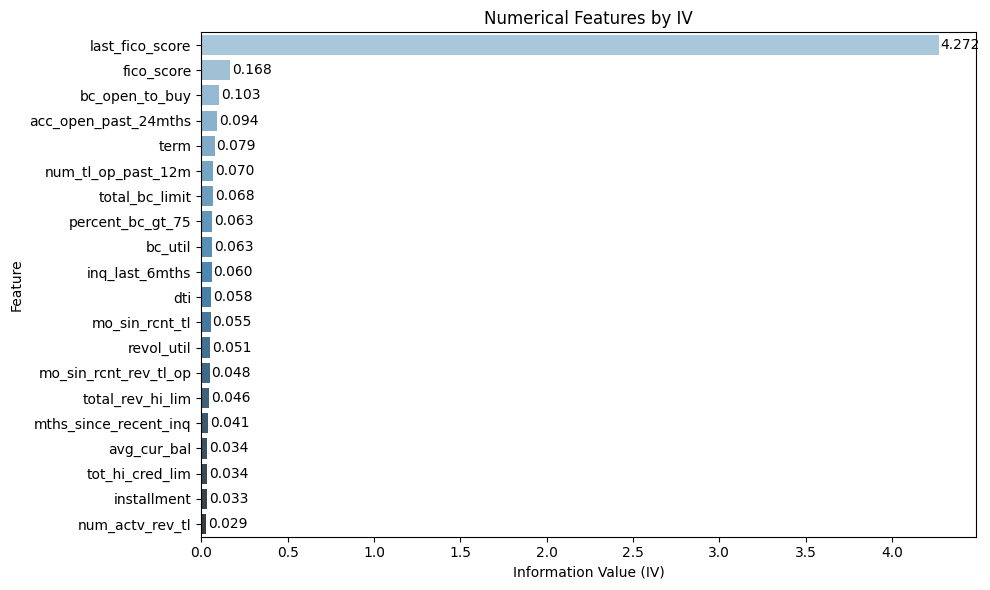

In [17]:

# Inspect features that are savable via feature engineering

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_iv_scores(
    useless_features,
    weak_features,
    medium_features,
    strong_features,
    sus_features,
    iv_threshold=0.02,
    top_n=None,
    title="Numerical Features by IV",
    figsize=(10,6)
):
    """
    Plot IV scores for selected features grouped by strength level.
    
    Parameters:
    - useless_features, weak_features, ..., sus_features: Lists of (feature, IV) tuples
    - iv_threshold: Minimum IV to show on the plot (default: 0.02)
    - top_n: Show only top N features by IV (optional)
    - title: Title of the plot
    - figsize: Figure size 
    """
    all_iv = (
        useless_features +
        weak_features +
        medium_features +
        strong_features +
        sus_features
    )

    iv_df = pd.DataFrame(all_iv, columns=["Feature", "IV"])
    iv_df = iv_df[iv_df["IV"] >= iv_threshold].sort_values(by="IV", ascending=False)

    if top_n:
        iv_df = iv_df.head(top_n)

    # Plotting
    num_bars = len(iv_df)
    plt.figure(figsize=(figsize[0], max(figsize[1], 0.02 * num_bars)))
    ax = sns.barplot(data=iv_df, x="IV", y="Feature", palette="Blues_d")

    for i, (iv, feature) in enumerate(zip(iv_df["IV"], iv_df["Feature"])):
        ax.text(iv + 0.01, i, f"{iv:.3f}", va='center', fontsize=10, color='black')

    plt.title(title)
    plt.xlabel("Information Value (IV)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.02, 20, figsize=(10,6))

In [18]:
def display_numerical_features_iv_category(useless, weak, medium, strong, sus, no_var): 
    # Numerical Features 
    print(f"Useless Numerical Features (IV < 0.02): {useless}\n")
    print(f"Weak Numerical Features (0.02 ≤ IV < 0.1): {weak}\n")
    print(f"Medium Numerical Features (0.1 ≤ IV < 0.3): {medium}\n")
    print(f"Strong Numerical Features (0.3 ≤ IV < 0.5): {strong}\n")
    print(f"Suspicious Numerical Features (IV ≥ 0.5): {sus}\n")
    print(f"No Variation Features:{no_var}")


display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)

Useless Numerical Features (IV < 0.02): [('delinq_2yrs', np.float64(0.008975621527214699)), ('open_acc', np.float64(0.015961679656043767)), ('pub_rec', np.float64(0.010288751696909007)), ('revol_bal', np.float64(0.003888723949435664)), ('total_acc', np.float64(0.019666232561313165)), ('collections_12_mths_ex_med', np.float64(0.0)), ('acc_now_delinq', np.float64(0.0)), ('chargeoff_within_12_mths', np.float64(0.0)), ('delinq_amnt', np.float64(0.0)), ('mo_sin_old_il_acct', np.float64(0.0030101377334820403)), ('mo_sin_old_rev_tl_op', np.float64(0.008203709215265677)), ('mort_acc', np.float64(0.005850973290228619)), ('num_accts_ever_120_pd', np.float64(0.004248525395214446)), ('num_actv_bc_tl', np.float64(0.004029093195103944)), ('num_bc_sats', np.float64(0.00042182881278004364)), ('num_bc_tl', np.float64(0.006352862067195134)), ('num_il_tl', np.float64(0.00952716634224076)), ('num_op_rev_tl', np.float64(0.01333037282311057)), ('num_rev_accts', np.float64(0.018005276906851463)), ('num_sats'

### 2.1 Categorical Features WoE & IV Feature Selection 

In [19]:
from pyspark.sql.types import StringType

target_col = "default_status"

# Extract all string-type categorical features
categorical_cols = [f.name for f in df.schema.fields 
                    if isinstance(f.dataType, StringType) and f.name != target_col]

# Binning strength categories
useless_cat_features = [] 
weak_cat_features = []
medium_cat_features = []
strong_cat_features = [] 
sus_cat_features = []
no_var_cat = []

for feature in categorical_cols:
    print(f"\n🔍 Feature: {feature}")

    # Step 1: Sample and convert to pandas
    sample_df = (
        df.select(feature, target_col)
        .sample(fraction=0.05, seed=42)
        .toPandas()
    )

    if sample_df[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        no_var_cat.append(feature)
        continue

    x = sample_df[feature]
    y = sample_df[target_col]

    # Step 2: Fit OptimalBinning for categorical feature
    optb = OptimalBinning(
        name=feature,
        dtype="categorical",
        solver="cp",
        monotonic_trend="auto_asc_desc"
    )
    optb.fit(x, y)

    # Step 3: Get binning table
    bin_table = optb.binning_table.build()


    # Convert bin_table to DataFrame
    bin_df = pd.DataFrame({
        "Bin": bin_table["Bin"],
        "Count": bin_table["Count"],
        "Default Rate (%)": bin_table["Event rate"],
        "WOE": bin_table["WoE"],
        "IV": bin_table["IV"]
    })

    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    
    bin_df = bin_df.astype(str)
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))

    # Step 4: Total IV
    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv}")


    total_iv = float(total_iv)
    
    # Step 5: Categorize feature
    if total_iv < 0.02: 
        useless_cat_features.append((feature, total_iv))
    elif total_iv < 0.1: 
        weak_cat_features.append((feature, total_iv))
    elif total_iv < 0.3: 
        medium_cat_features.append((feature, total_iv))
    elif total_iv < 0.5: 
        strong_cat_features.append((feature, total_iv))
    else: 
        sus_cat_features.append((feature, total_iv))




🔍 Feature: home_ownership
╒══════════════════════╤═════════╤════════════════════╤═════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                 │          IV │
╞══════════════════════╪═════════╪════════════════════╪═════════════════════╪═════════════╡
│ ['OTHER' 'MORTGAGE'] │   53922 │           0.096992 │ 0.11162926501081127 │ 0.00591323  │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ ['OWN']              │   12184 │           0.106041 │ 0.01236296699139583 │ 1.70411e-05 │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ ['RENT']             │   42644 │           0.120486 │ -0.1316371809696686 │ 0.00715454  │
├──────────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ Special              │       0 │           0        │ 0.0                 │ 0           │
├──────────────────────┼─────────┼───────────────────

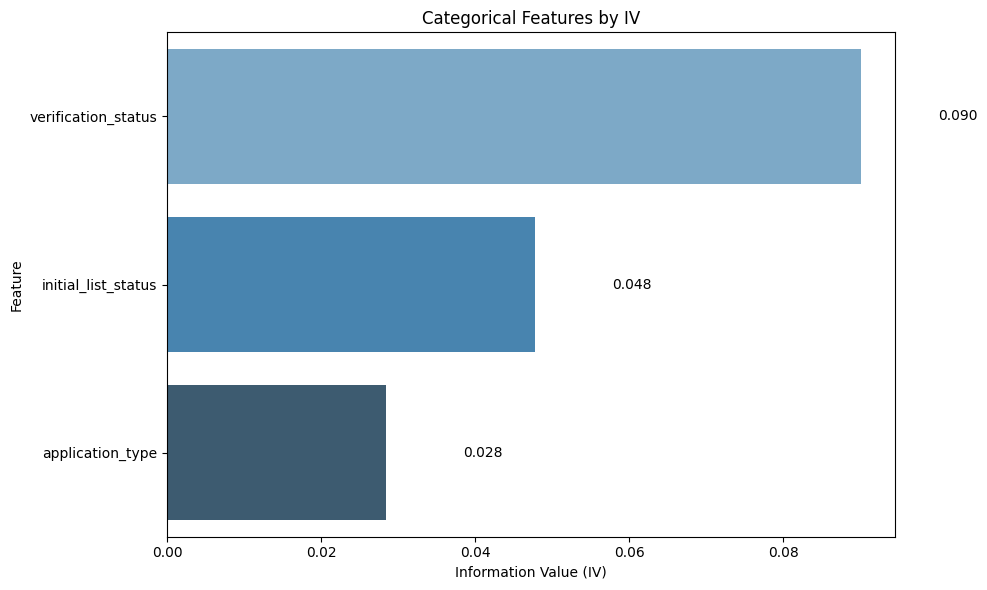

In [20]:
# Categorical Features
all_iv_cat = (
    useless_cat_features +
    weak_cat_features +
    medium_cat_features +
    strong_cat_features +
    sus_cat_features
)

iv_df_cat = pd.DataFrame(all_iv_cat, columns=["Feature", "IV"])

# Sort by IV descending and take top 10
iv_df_cat = iv_df_cat[iv_df_cat['IV'] >= 0.02 ].sort_values(by="IV", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=iv_df_cat, x="IV", y="Feature", palette="Blues_d")


# Add IV value at the end of each bar
for i, (iv, feature) in enumerate(zip(iv_df_cat["IV"], iv_df_cat["Feature"])):
    ax.text(iv + 0.01, i, f"{iv:.3f}", va='center', fontsize=10, color='black')
    
plt.title("Categorical Features by IV") 
plt.xlabel("Information Value (IV)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [21]:
# Categorical Features 
print(f"Useless Categorical Features (IV < 0.02): {useless_cat_features}")
print(f"Weak Categorical Features (0.02 ≤ IV < 0.1): {weak_cat_features}")
print(f"Medium Categorical Features (0.1 ≤ IV < 0.3): {medium_cat_features}")
print(f"Strong Categorical Features (0.3 ≤ IV < 0.5): {strong_cat_features}")
print(f"Suspicious Categorical Features (IV ≥ 0.5): {sus_cat_features}")
print(f"No Variation Features: {no_var_cat}")

Useless Categorical Features (IV < 0.02): [('home_ownership', 0.013084807953267425)]
Weak Categorical Features (0.02 ≤ IV < 0.1): [('verification_status', 0.09007478506869401), ('initial_list_status', 0.04775733607857334), ('application_type', 0.028417002066930597)]
Medium Categorical Features (0.1 ≤ IV < 0.3): []
Strong Categorical Features (0.3 ≤ IV < 0.5): []
Suspicious Categorical Features (IV ≥ 0.5): []
No Variation Features: ['pymnt_plan']


Compiled from IV Values shown from numerical and categorical variables, it seems that we can safely drop some un-useful features for credit risk modeling. Normally, credit risk models just require a few strong features with maximised predictive values. Furthermore, we can observe that the IV Score of `last_fico_score` seems too good to be true. Upon further research, I realised that it is leaky, since it refers to the last credit report pull FICO score throughout the lifepsan of a loan. In lieu of that, this feature shall be dropped as well. This is often referred to as a data leak, which is unfavorable when included as 1 of our features in our machine learning model. 

In [22]:
# Dropping unfavorable features 

df = df.drop('last_fico_score')
df = df.drop(*[feature for feature, iv in useless_features if feature != 'delinq_2yrs']) # shall not be dropped due to how delinquencies are srs in credit risk modeling
df = df.drop(*[feature for feature, iv in useless_cat_features])
df = df.drop(* (no_var_cat + no_variation_features))

# 3. Feature Engineering (Interaction Features)
Now, I will be manually inspecting each column, to check if I can create any interaction features. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling. 
<br>




The following features can be combined so our future models can capture the joint effect of both features. An efficient workflow would be to explore the dataset via different grouping/segments, to check if they have indeed a clear difference in risk levels. I will sample the data to simulate a big data environment, where the massive volumes of data make it almost impossible to visualise the entire dataset. 


In [23]:
# fico_score_loan_amnt: Credit worthiness per dollar of loan borrowed 
# installment_term_annual_inc_ratio (how much is total repayment [principal + interest] is relative to annual income)
# loan_amnt / annual_inc_ratio (Principal sum relative to annual income)
# bc_open_to_buy / annual_inc: Proportion of borrower's income available to spend on revolving credits 
# acc_optn_past_24mths * revol_util: When both is high, amplified red flag (financial desparation)
# num_tl_op_past_12m * delinq_2yrs: Fianncial desperation * Bad credit history amplifies credit risk
#  num_tl_op_past_12m * inq_last_6mths: Financial desperation 
# delinq_2yrs_inq_last_6mths: Having numbers in both greatly amplifies financial desperation / credit risk than having one of them 
# total_rev_hi_lim / annual_inc : Measures financial flexibility (how much can borrower borrow given income)
# dti * inq_last_6mths : high dti and high number of inquiries signal financial distress 
# dti / fico score : High values signal high credit risk (overextended borrowers who have seemingly high fico scores)
# dti * delinq_2yrs : Check bad credit history and if debt exceeds income -> bad credit risk 
# dti * revol_util : High utilisation rate and high dti can possibly signal high PD
# revol_util * delinq_2yrs : Signals dangerous borrower 


from pyspark.sql.functions import lit # lit() is to prevent 0 divisions

df = df.withColumn('fico_score_loan_amnt', col('fico_score') / (col('loan_amnt')  + lit(1)  ))
df = df.withColumn("installment_term_annual_inc_ratio", (col("installment") * col("term")) / (col("annual_inc") + lit(1)))
df = df.withColumn("loan_amnt_annual_inc_ratio", col("loan_amnt") / (col("annual_inc") + lit(1)))
df = df.withColumn("bc_open_to_buy_annual_inc_ratio", col("bc_open_to_buy") / (col("annual_inc") + lit(1)))
df = df.withColumn("acc_open24m_revol_util", col("acc_open_past_24mths") * col("revol_util"))
df = df.withColumn("tl_op12m_delinq", col("num_tl_op_past_12m") * col("delinq_2yrs"))
df = df.withColumn("tl_op12m_inq6m", col("num_tl_op_past_12m") * col("inq_last_6mths"))
df = df.withColumn("delinq_inq", col("delinq_2yrs") * col("inq_last_6mths"))
df = df.withColumn("rev_limit_annual_inc_ratio", col("total_rev_hi_lim") / (col("annual_inc") + lit(1)))
df = df.withColumn("dti_inq", col("dti") * col("inq_last_6mths"))
df = df.withColumn("dti_fico_ratio", col("dti") / (col("fico_score") + lit(1)))
df = df.withColumn("dti_delinq", col("dti") * col("delinq_2yrs"))
df = df.withColumn("dti_revol_util", col("dti") * col("revol_util"))
df = df.withColumn("revol_util_delinq", col("revol_util") * col("delinq_2yrs"))

/var/folders/71/ljlh3xcn18gbcvg1hb44wqdh0000gn/T/ipykernel_2681/3998666300.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=sample_pdf, x=feature, hue='default_status', ax =  axes[i], fill=True)


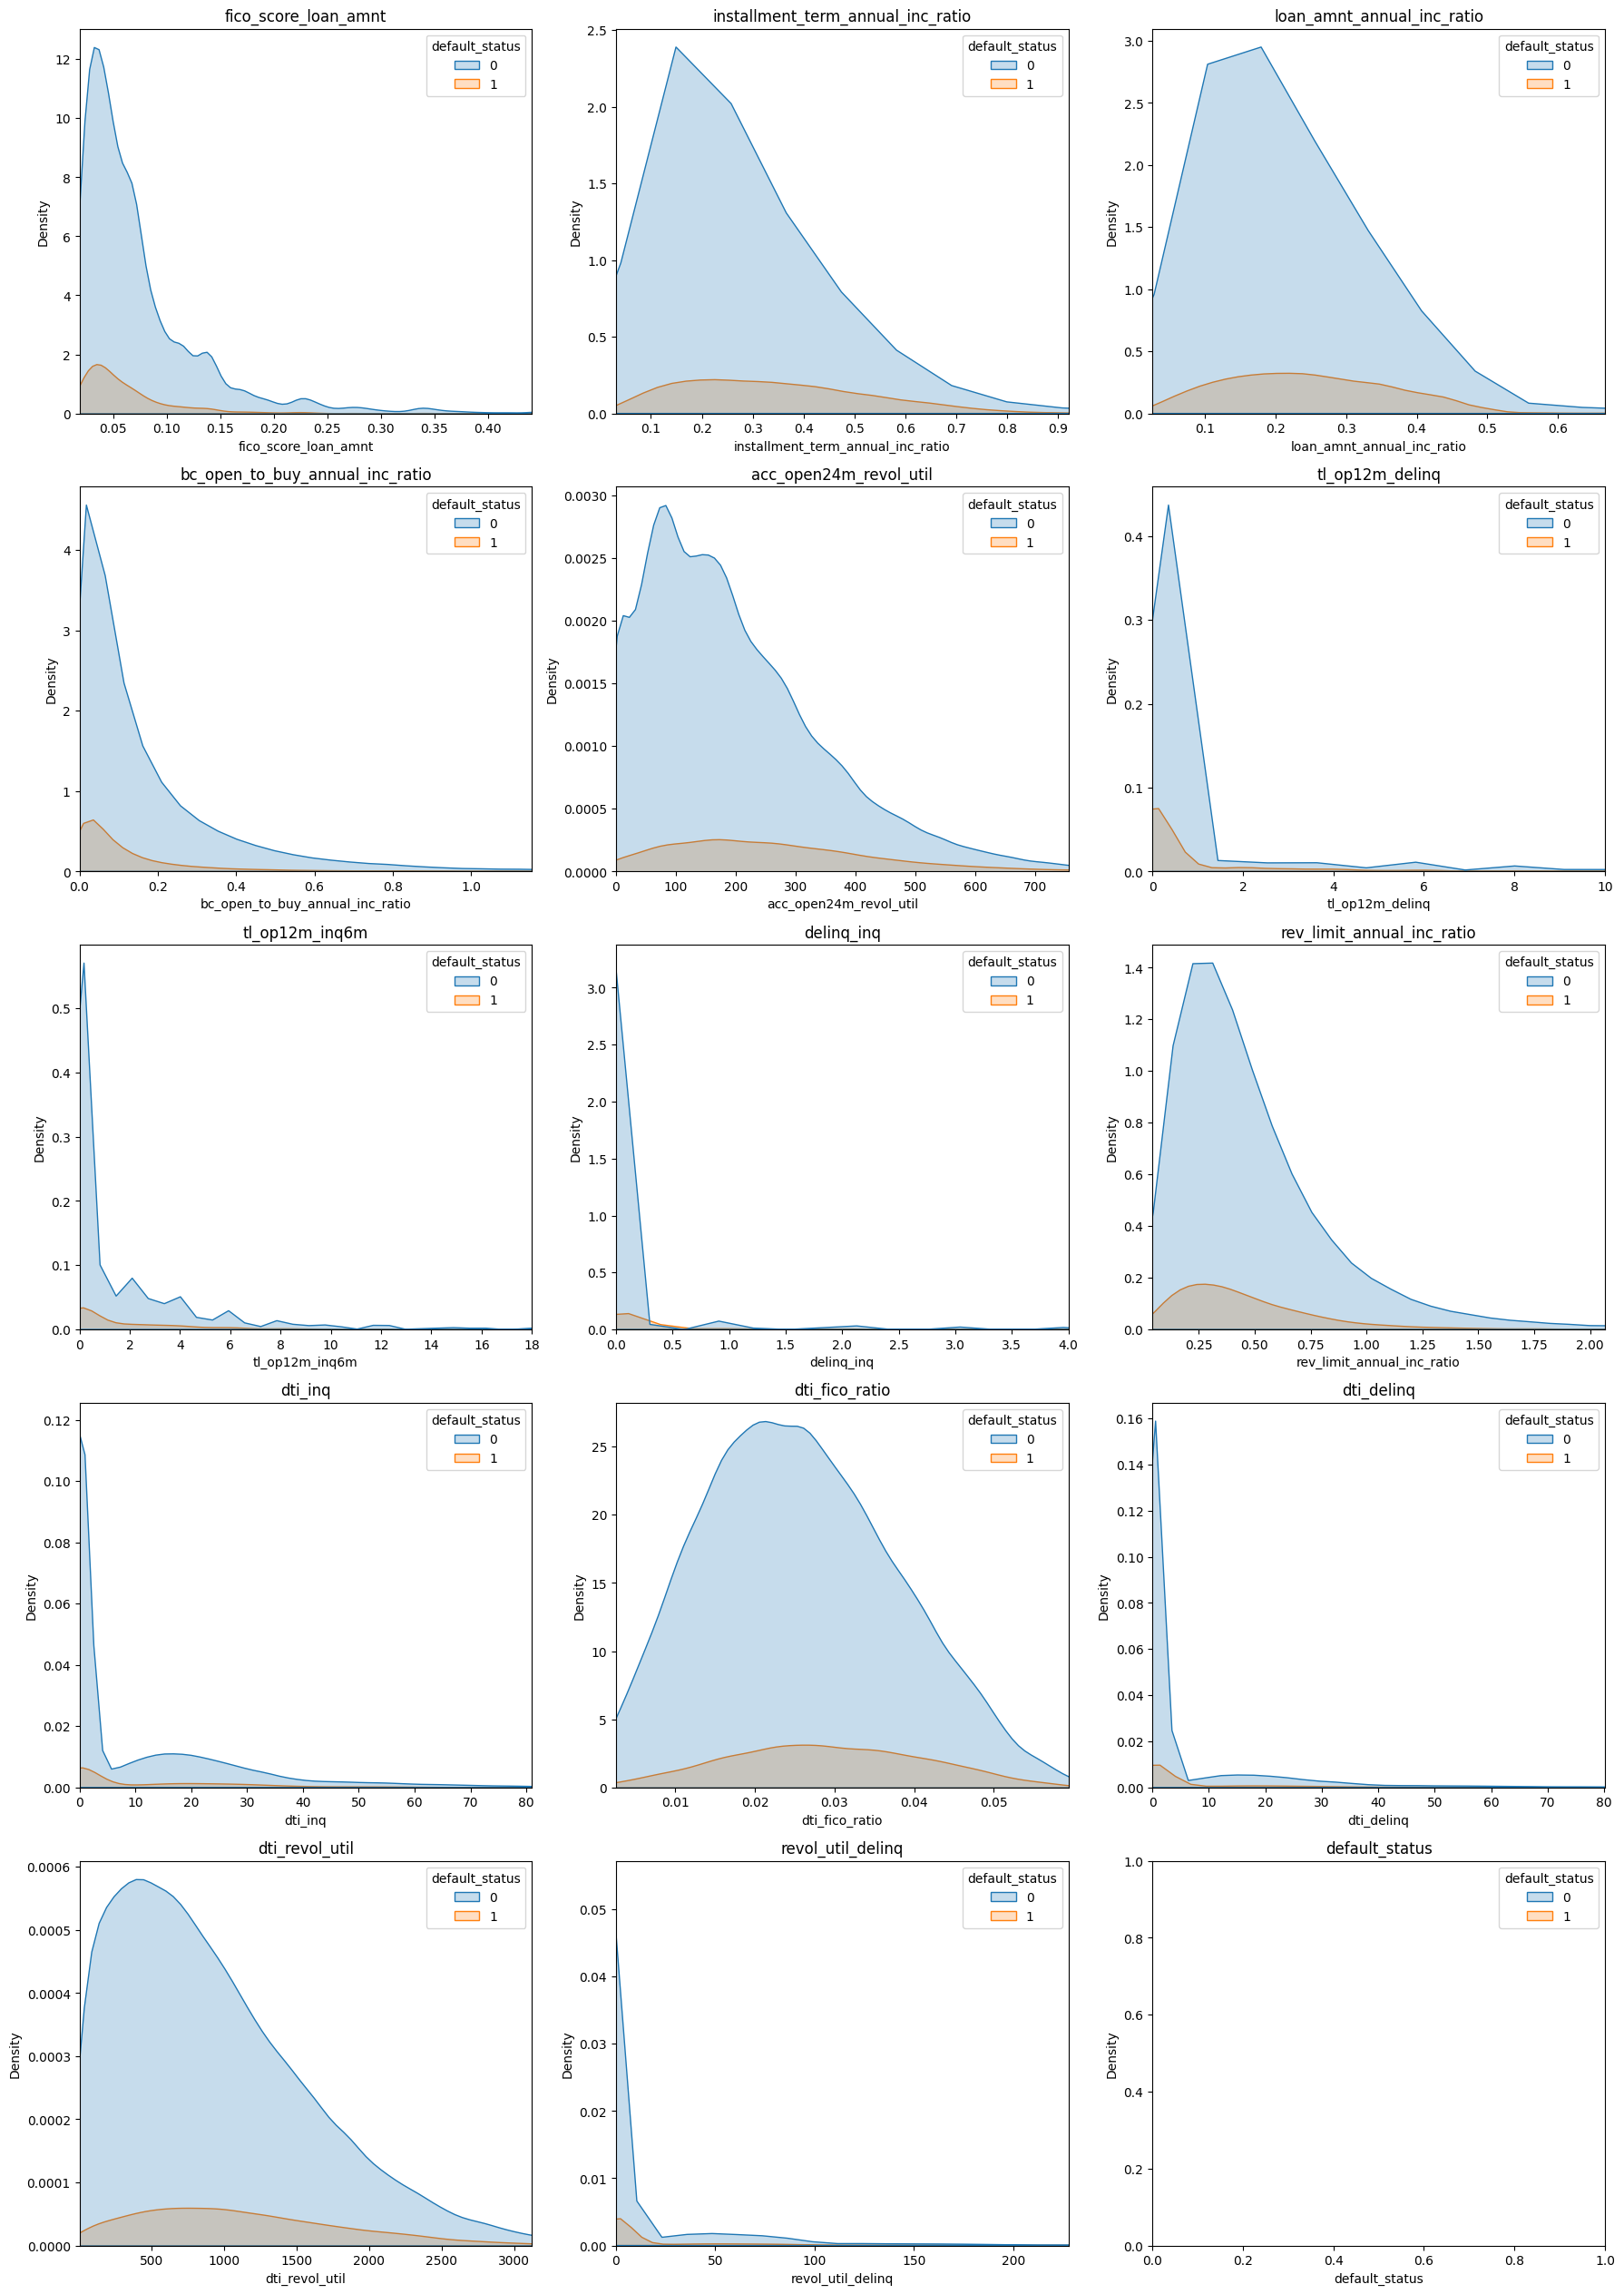

In [24]:
# Visualisation Code 
import matplotlib.pyplot as plt
import seaborn as sns

# Stratified sampling 
sample_pdf = df.select(
    col("fico_score_loan_amnt"),
    col("installment_term_annual_inc_ratio"),
    col("loan_amnt_annual_inc_ratio"),
    col("bc_open_to_buy_annual_inc_ratio"),
    col("acc_open24m_revol_util"),
    col("tl_op12m_delinq"),
    col("tl_op12m_inq6m"),
    col("delinq_inq"),
    col("rev_limit_annual_inc_ratio"),
    col("dti_inq"),
    col("dti_fico_ratio"),
    col("dti_delinq"),
    col("dti_revol_util"),
    col("revol_util_delinq"),
    col("default_status")
    
).sample(fraction=0.05, seed=42).toPandas()


num_rows = len(sample_pdf.columns) // 3 + 1 # total num of new interaction features // 3 + 1 
num_cols = 3 

# Set up 3 subplots side-by-side
fig, axes = plt.subplots(   num_rows    ,   num_cols    , figsize=(2 * 9 , 2 * 15 ))
axes = axes.flatten() 

for i, feature in enumerate(sample_pdf.columns) : 
    sns.kdeplot(data=sample_pdf, x=feature, hue='default_status', ax =  axes[i], fill=True)
    axes[i].set_title(feature)
    q_low, q_high = sample_pdf[feature].quantile([0.01, 0.99])
    axes[i].set_xlim(q_low, q_high)

for ax in axes[len(sample_pdf.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

As seen above, there are certain interaction features that are estimated to be strong or at least moderately predictive features. It would be great if we see clear differences in positions of x-axis values of the peaks of different classes (default vs non-default). I have categorised them into the following. Subsequently, we will run the `optbinning` library to conduct another round of WoE binning, to obtain the new list of best features to include in our model. 

In [25]:
# Round 2 WoE binning after feature engineering
useless_features = [] 
weak_features = []
medium_features = []
strong_features = [] 
sus_features = []
no_variation_features = []

numerical_cols = [f.name for f in df.schema.fields 
                  if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType)) and f.name != target_col]

for feature in numerical_cols:
    if feature != 'id':
        print(f"\n🔍 Feature: {feature}")

        # Step 1: Sample from PySpark and convert to pandas
        sample_df = (
            df.select(feature, target_col)
            .sample(fraction=0.05, seed=42)  # 5% sample from big data
            .toPandas()
        )

        if sample_df[feature].nunique() < 2:
            print("⚠️ Not enough variation. Skipping.")
            no_variation_features.append(feature)
            continue

        x = sample_df[feature]
        y = sample_df[target_col]

        display_feature_iv_score(feature, x, y, 'numerical', useless_features, weak_features, medium_features, strong_features, sus_features, interaction='interaction')


🔍 Feature: loan_amnt
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3412.50)      │    5539 │             0.0733 │ 0.41761820049886333  │ 0.00753741  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3412.50, 5537.50)   │    9814 │             0.0809 │ 0.3106419493498267   │ 0.00770623  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5537.50, 10012.50)  │   27758 │             0.0953 │ 0.13165833511762504  │ 0.00420109  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [10012.50, 12037.50) │    9882 │             0.1148 │ -0.07640030495074601 │ 0.000546538 │
├──────────────────────┼─────────┼──────────────

In [26]:

display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)


Useless Numerical Features (IV < 0.02): [('delinq_2yrs', np.float64(0.008975621527214699)), ('tl_op12m_delinq', np.float64(0.017621450501992323)), ('delinq_inq', np.float64(0.017414693282028108)), ('rev_limit_annual_inc_ratio', np.float64(0.011281560281957917)), ('dti_delinq', np.float64(0.0)), ('revol_util_delinq', np.float64(0.011660761098332407))]

Weak Numerical Features (0.02 ≤ IV < 0.1): [('loan_amnt', np.float64(0.028700565466454844)), ('term', np.float64(0.07867342129999688)), ('installment', np.float64(0.033070690758381316)), ('annual_inc', np.float64(0.02563542487977294)), ('dti', np.float64(0.058261073806227165)), ('inq_last_6mths', np.float64(0.05987168026602282)), ('revol_util', np.float64(0.050575674749277995)), ('tot_cur_bal', np.float64(0.023612399400714093)), ('total_rev_hi_lim', np.float64(0.04585071558922235)), ('acc_open_past_24mths', np.float64(0.09374410030040327)), ('avg_cur_bal', np.float64(0.03373935714506)), ('bc_util', np.float64(0.06296514920852986)), ('mo_s

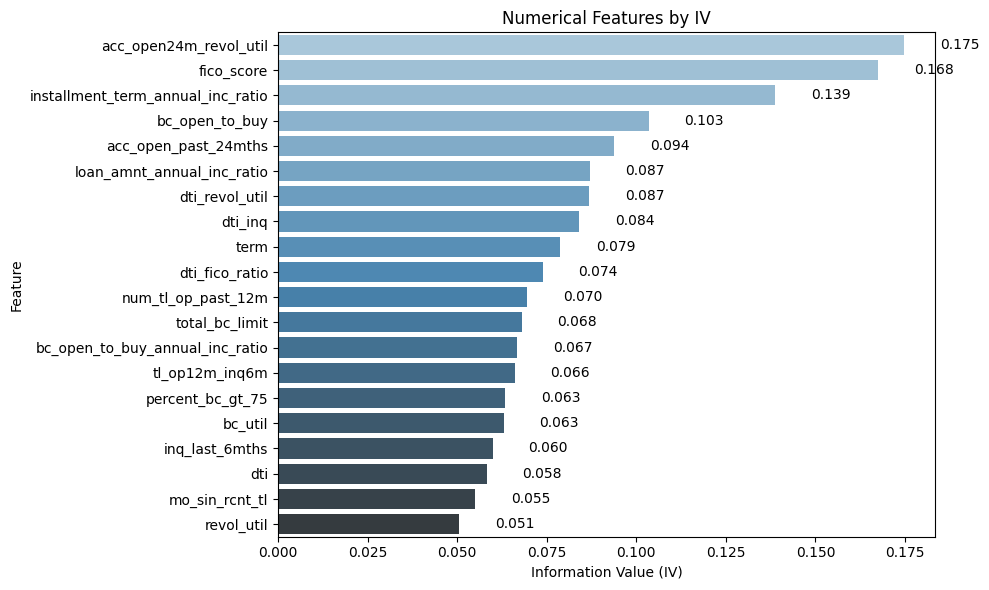

In [27]:
plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.02, 20, figsize=(10,6))


Now, let's re-attempt to group our base features into different groups. Ideally, we should interact across different groups in credit risk modeling to allow our model to figure underlying patterns. 

| **Category**                                           | **Description & Usage**                                                        | **Your Base Variables**                                                                                                                                       |
| ------------------------------------------------------ | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Affordability & Debt Burden**                     | Ability to repay relative to income and existing debt                          | `loan_amnt`, `installment`, `term`, `annual_inc`, `dti`                                                                                                       |
| **2. Credit History & Payment Discipline**             | Historical performance and willingness to repay debt                           | `fico_score`, `delinq_2yrs`  , `inq_last_6mths`,                                                                                                                                 |
| **3. Revolving Credit Utilization** | Revolving credit line utilization and available cushion                        | `revol_util`, `bc_util`, `bc_open_to_buy`, `total_rev_hi_lim`, `tot_hi_cred_lim`, `total_bc_limit`, `tot_cur_bal`, `avg_cur_bal`, `percent_bc_gt_75`          |
| **4. Recent Credit Behavior & Appetite**               | Recent borrower credit-seeking actions (e.g., inquiries, new account openings) |  `num_tl_op_past_12m`, `acc_open_past_24mths`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_rcnt_tl`, `mths_since_recent_bc`, `mths_since_recent_inq`    |
| **5. Credit Profile Characteristics**                  | Credit history length, borrower profile, application-level flags & details     | `earliest_cr_line`, `num_actv_rev_tl`, `num_rev_tl_bal_gt_0`, `application_type`, `initial_list_status`, `verification_status`|



In [28]:

df = df.withColumn('fico_score_revol_util',  col('fico_score') / (   col('revol_util') + lit(1)  )) # if fico score is low, high_revol_util would be worse
df = df.withColumn('dti_bc_util', col('dti') * col('bc_util') ) # amplifies risk when a borrower has both high dti and high current usage of credit
df = df.withColumn('loan_amnt_bc_open_to_buy', col('loan_amnt') / (col('bc_open_to_buy') + lit(1))  )  # large loan amounts relative available credit left greatly amplifies risk 
df = df.withColumn('pct_bc_gt_75_delinq_2yrs', col('percent_bc_gt_75') * col('delinq_2yrs') ) # Flags borrowers already running most cards > 75 % who also have past delinquencies
df = df.withColumn('dti_inq', col('dti') * col('inq_last_6mths') ) # high dti and financial desperation from recent inquiries signal higher risk 



# 1. Encode verification_status (e.g., 'verified' or 'source_verified' → 1, others → 0)
df = df.withColumn("is_verified", when(col("verification_status").isin("Verified", "Source Verified"), 1).otherwise(0))

# Interaction: dti * is_verified
df = df.withColumn("dti_verified_ratio", col("dti") / (col("is_verified") + lit(1)) ) # assuming that verified borrowers are lower risk at same dti 

df = df.withColumn('dti_verified_multiply', col('dti') * col('is_verified')) # assume dti comparison only applies when borrowers' credit reports/info obtained is verified

# 2. Encode initial_list_status ('f' for fractional = 1, else 0)
df = df.withColumn("is_fractional", when(col("initial_list_status") == "f", 1).otherwise(0))

# Interaction: revol_util * is_fractional
df = df.withColumn("revol_util_fractional", col("revol_util") * col("is_fractional")) # fractional loans are supplied by retail investors, and more risky. when such loans are sponsored to borrowers with high revolving utilisation rate, loan probably has higher default probablity 


In [29]:
useless_features = [] 
weak_features = [] 
medium_features = [] 
strong_features = [] 
sus_features = []

numerical_cols = [feature.name for feature in df.schema.fields if feature.name not in ('default_status', 'id') and isinstance(feature.dataType, NumericType)]
target_col ='default_status'

for feature in numerical_cols:
    if feature != 'id':
        print(f"\n🔍 Feature: {feature}")

        # Step 1: Sample from PySpark and convert to pandas
        sample_df = (
            df.select(feature, target_col)
            .sample(fraction=0.05, seed=42)  # 5% sample from big data
            .toPandas()
        )

        if sample_df[feature].nunique() < 2:
            print("⚠️ Not enough variation. Skipping.")
            no_variation_features.append(feature)
            continue

        x = sample_df[feature]
        y = sample_df[target_col]

        
        display_feature_iv_score(feature, x, y, 'numerical', 
                                 useless_features, weak_features, medium_features, strong_features, sus_features, 'interaction')
                


🔍 Feature: loan_amnt
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3412.50)      │    5539 │             0.0733 │ 0.41761820049886333  │ 0.00753741  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3412.50, 5537.50)   │    9814 │             0.0809 │ 0.3106419493498267   │ 0.00770623  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5537.50, 10012.50)  │   27758 │             0.0953 │ 0.13165833511762504  │ 0.00420109  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [10012.50, 12037.50) │    9882 │             0.1148 │ -0.07640030495074601 │ 0.000546538 │
├──────────────────────┼─────────┼──────────────

In [30]:
display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)

Useless Numerical Features (IV < 0.02): [('delinq_2yrs', np.float64(0.008975621527214699)), ('tl_op12m_delinq', np.float64(0.017621450501992323)), ('delinq_inq', np.float64(0.017414693282028108)), ('rev_limit_annual_inc_ratio', np.float64(0.011281560281957917)), ('dti_delinq', np.float64(0.0)), ('revol_util_delinq', np.float64(0.011660761098332407)), ('pct_bc_gt_75_delinq_2yrs', np.float64(0.011230126396579485)), ('dti_verified_ratio', np.float64(0.014437882582595601))]

Weak Numerical Features (0.02 ≤ IV < 0.1): [('loan_amnt', np.float64(0.028700565466454844)), ('term', np.float64(0.07867342129999688)), ('installment', np.float64(0.033070690758381316)), ('annual_inc', np.float64(0.02563542487977294)), ('dti', np.float64(0.058261073806227165)), ('inq_last_6mths', np.float64(0.05987168026602282)), ('revol_util', np.float64(0.050575674749277995)), ('tot_cur_bal', np.float64(0.023612399400714093)), ('total_rev_hi_lim', np.float64(0.04585071558922235)), ('acc_open_past_24mths', np.float64(

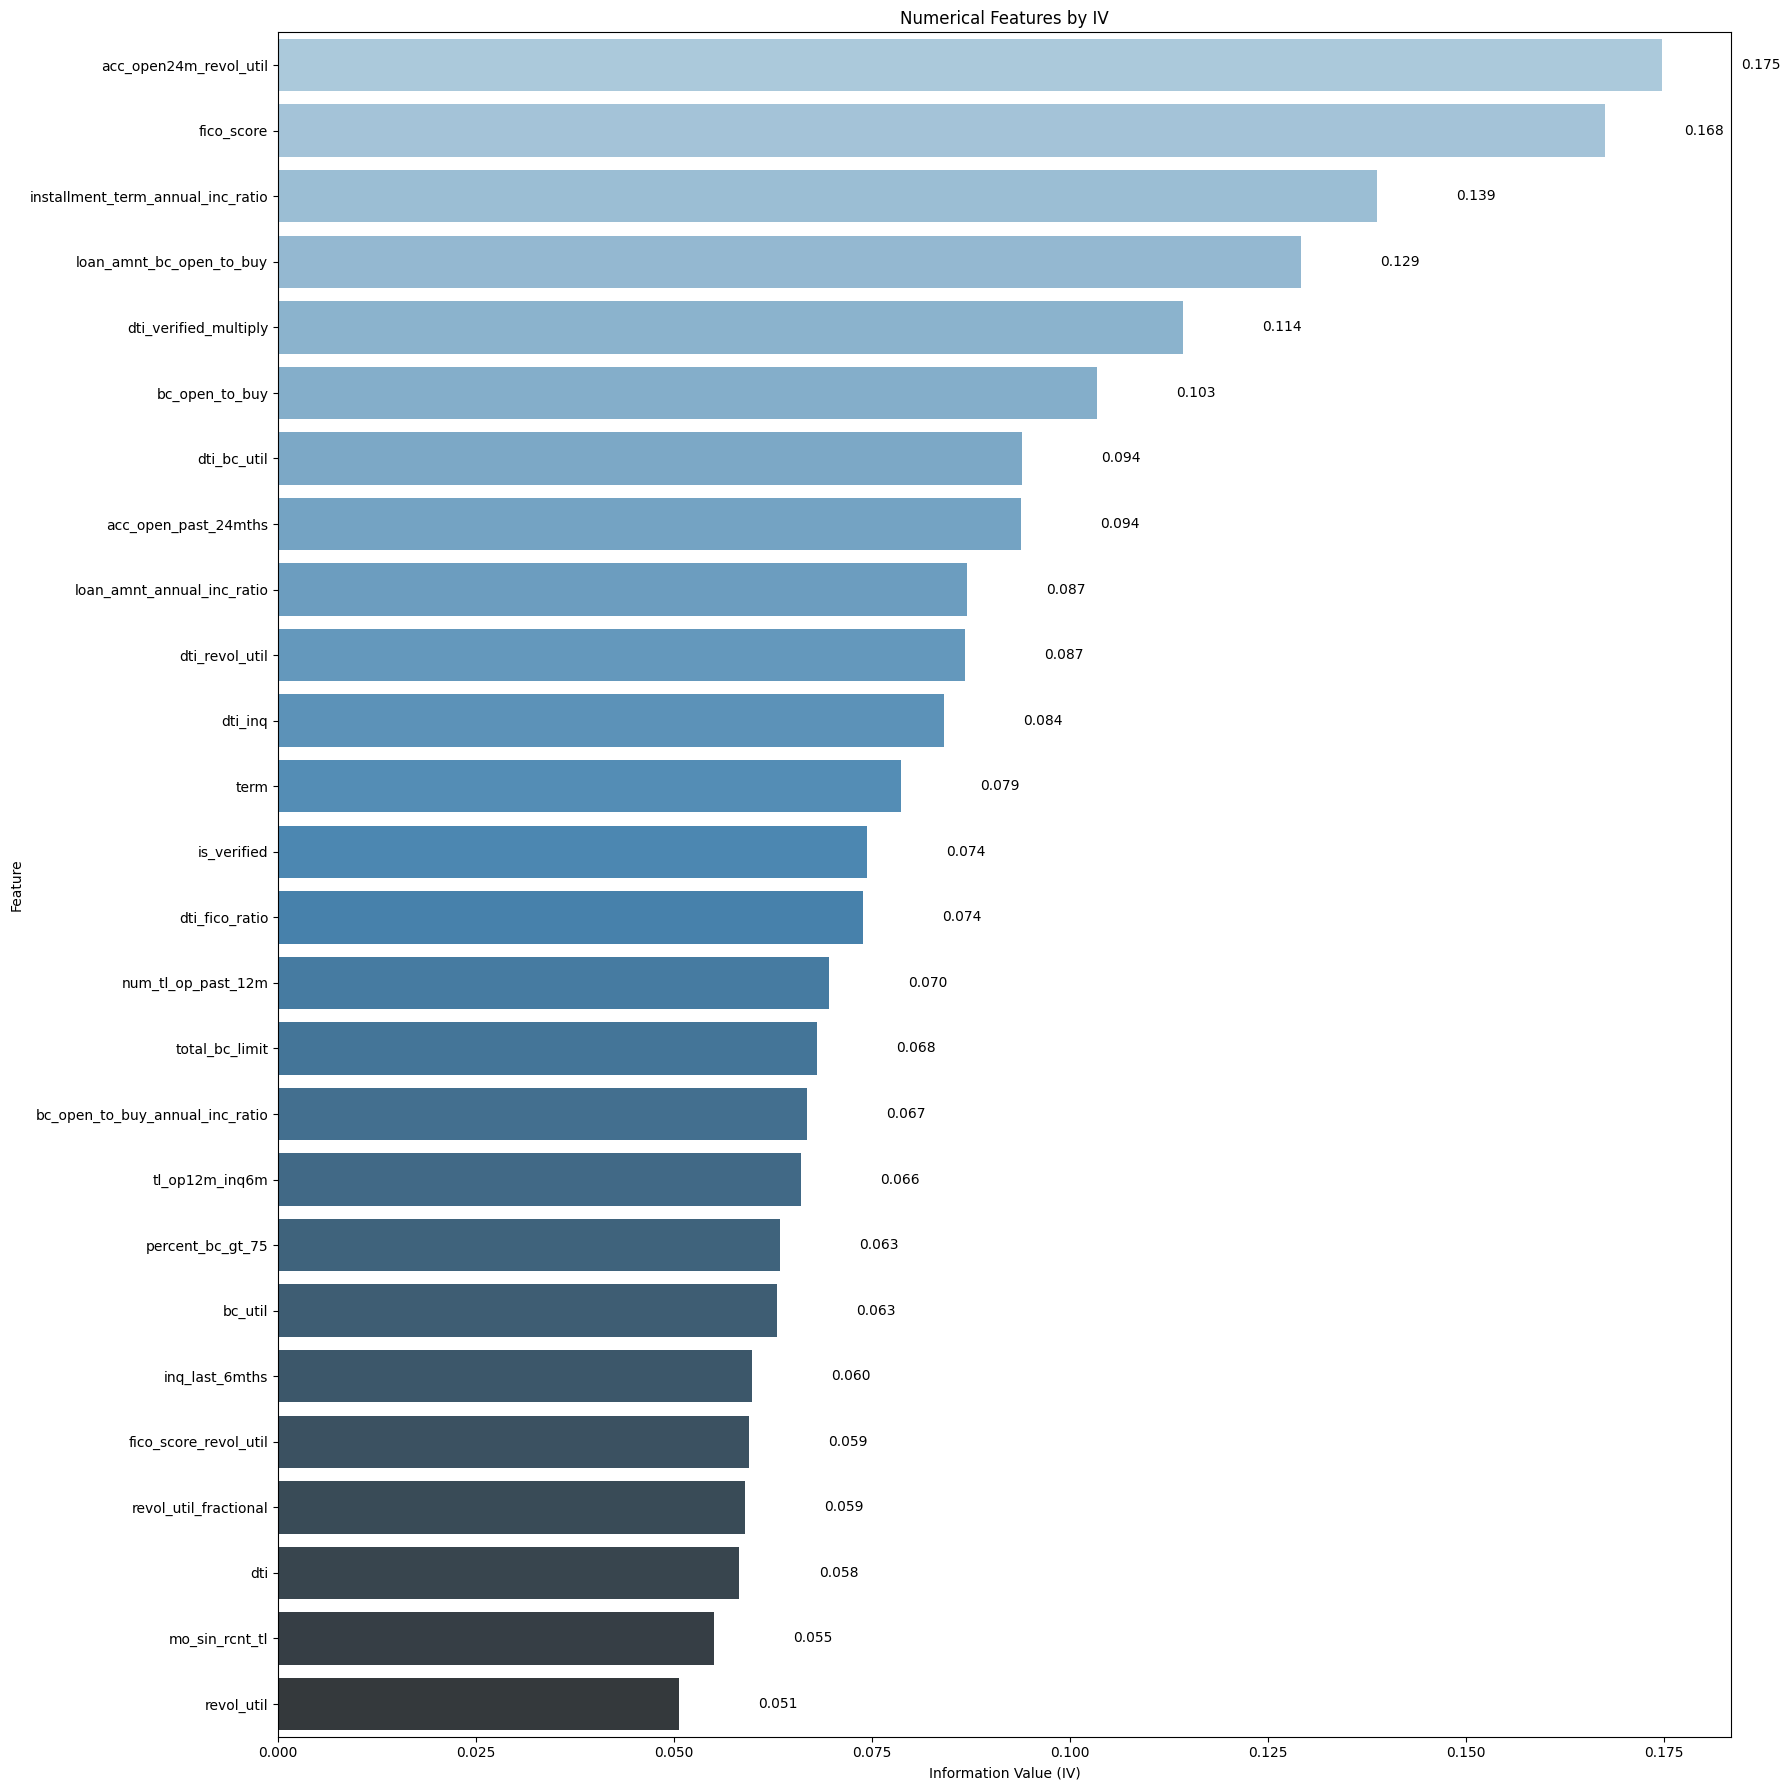

In [31]:
plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.05, figsize=(18,18))

# 4. Multicollinearity Handling 

Multicollinearity occurs when two or more features in a dataset are highly correlated with each other. This can lead to:

- 🚫 **Unstable model coefficients**
- 📉 **Reduced model interpretability**
- ⚠️ **Overfitting and inflated variance**

In credit risk modeling, we handle multicollinearity to ensure model robustness and regulatory compliance. To do so, we shall utitlise the `statsmodels` library on a sampled Pandas DataFrame obtained from our dataset. From there, we shall compute the VIF (Variance Inflation Factor), which tells us how much 'extra noise' is added to the estimate of a variable, due to how it overlaps with other variables. 

   - VIF < 5 → Acceptable
   - 5 ≤ VIF < 10 → Moderate concern
   - VIF ≥ 10 → Consider removing or combining feature

In [32]:
# one-hot encoding of used categorical features

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 1: String index the categorical feature
indexer = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")
df = indexer.fit(df).transform(df)

# Step 2: One-hot encode the indexed feature:  
# IS217 Analytics Foundation in SMU taught me about the importance of how one-hot encoding is perfect multicollinearity in itself. 
# Dummy Encoding Hence, 1 of them will have to be dropped to prevent perfect multicollinearity
encoder = OneHotEncoder(inputCol="verification_status_index", outputCol="verification_status_ohe", dropLast=True)
df = encoder.fit(df).transform(df)

In [33]:

# 1. Define features I want to select to check for multicollinearity after feature engineering 
selected_features = [f if f != "verification_status" else "verification_status_ohe"
                     for f, iv in (weak_features + medium_features + strong_features + weak_cat_features)
                     if iv >= 0.05 and f not in ('id', 'default_status')] # verification_status -> verification_status_ohe (flag for one hot encoding)



# 2. Split OHE Vector into columns in original_df -> Creating 2 new columns (dummy encoding)
from pyspark.ml.functions import vector_to_array
df = df.withColumn('verification_status_ohe_array', vector_to_array("verification_status_ohe"))
num_ohe_cols = df.select("verification_status_ohe_array").head()[0].__len__()
for i in range(num_ohe_cols):
    df = df.withColumn(f"verification_status_{i+1}", col("verification_status_ohe_array")[i])


# 3. Sample Big Data
raw_features = [f for f in selected_features if "verification_status" not in f]
df_sampled = df.sample(fraction=0.05, seed=42)
features_pdf = df_sampled.select(*raw_features).toPandas()


# 5. Compute VIF for each feature in features_pdf (sampled data)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = sm.add_constant(features_pdf)
for i in range(X.shape[1]):
    print(f"VIF for {X.columns[i]}: {variance_inflation_factor(X.values, i):.2f}")




VIF for const: 2980.10
VIF for term: 1.78
VIF for dti: 569.62
VIF for inq_last_6mths: 6.93
VIF for revol_util: 19.31
VIF for acc_open_past_24mths: 6.47
VIF for bc_util: 19.80
VIF for mo_sin_rcnt_tl: 1.51
VIF for num_tl_op_past_12m: 3.52
VIF for percent_bc_gt_75: 3.67
VIF for total_bc_limit: 4.94
VIF for loan_amnt_annual_inc_ratio: 32.84
VIF for bc_open_to_buy_annual_inc_ratio: 2.97
VIF for tl_op12m_inq6m: 4.05
VIF for dti_inq: 5.86
VIF for dti_fico_ratio: 638.22
VIF for dti_revol_util: 36.63
VIF for fico_score_revol_util: 1.33
VIF for dti_bc_util: 37.33
VIF for is_verified: 5.10
VIF for revol_util_fractional: 1.19
VIF for bc_open_to_buy: 8.24
VIF for fico_score: 5.85
VIF for installment_term_annual_inc_ratio: 35.44
VIF for acc_open24m_revol_util: 5.68
VIF for loan_amnt_bc_open_to_buy: 1.03
VIF for dti_verified_multiply: 7.67


From the results above, multicollinearity results seem alarming. However, upon further inspection, we do have several features which are similar. For example, we created interaction features which are highly dependent on their base features. For such cases, we shall select the interaction feature which yield the highest IV score, and drop the rest.

In [34]:
col_to_drop = ['term', 'dti', 'inq_last_6mths', 'revol_util', 'is_verified', 'bc_util', 'dti_fico_ratio', 'bc_open_to_buy', 'bc_open_to_buy_annual_inc_ratio',
            'fico_score_revol_util']

features_pdf = features_pdf.drop(columns= col_to_drop)

In [35]:
features_pdf.head(10)

,acc_open_past_24mths,mo_sin_rcnt_tl,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,loan_amnt_annual_inc_ratio,tl_op12m_inq6m,dti_inq,dti_revol_util,dti_bc_util,revol_util_fractional,fico_score,installment_term_annual_inc_ratio,acc_open24m_revol_util,loan_amnt_bc_open_to_buy,dti_verified_multiply
0,4.0,13.0,0.0,60.0,11500.0,0.307683,0.0,0.00,1096.865,1096.865,0.0,677.0,0.540131,242.0,2.198285,18.13
1,2.0,9.0,1.0,0.0,7500.0,0.149993,0.0,0.00,1091.299,1234.981,0.0,777.0,0.175437,63.8,0.626174,0.00
2,10.0,3.0,6.0,0.0,35900.0,0.063636,18.0,33.90,93.790,100.570,8.3,697.0,0.070959,83.0,0.213923,0.00
3,3.0,4.0,2.0,25.0,9000.0,0.447402,0.0,0.00,671.840,687.895,0.0,717.0,0.527769,163.2,2.004008,12.35
4,2.0,11.0,2.0,0.0,6900.0,0.288882,0.0,0.00,321.507,164.994,0.0,697.0,0.337872,83.4,2.395872,7.71
5,0.0,56.0,0.0,100.0,8400.0,0.287021,0.0,24.87,2016.957,2432.286,81.1,687.0,0.388706,0.0,17.204301,24.87
6,2.0,1.0,1.0,50.0,3000.0,0.503113,0.0,0.00,537.510,952.020,0.0,692.0,0.623621,87.4,11.799410,12.30
7,3.0,5.0,1.0,33.3,15300.0,0.689576,0.0,0.00,128.234,177.148,19.4,757.0,0.953305,58.2,1.475183,6.61
8,6.0,9.0,1.0,0.0,21400.0,0.199996,0.0,0.00,91.991,137.300,0.0,747.0,0.223008,40.2,0.519103,13.73
9,3.0,9.0,1.0,100.0,3800.0,0.061538,0.0,0.00,649.766,719.144,0.0,682.0,0.069894,261.3,29.197080,0.00


In [36]:
X = sm.add_constant(features_pdf)
for i in range(X.shape[1]):
    print(f"VIF for {X.columns[i]}: {variance_inflation_factor(X.values, i):.2f}")

VIF for const: 708.07
VIF for acc_open_past_24mths: 4.90
VIF for mo_sin_rcnt_tl: 1.44
VIF for num_tl_op_past_12m: 3.40
VIF for percent_bc_gt_75: 2.30
VIF for total_bc_limit: 1.21
VIF for loan_amnt_annual_inc_ratio: 22.41
VIF for tl_op12m_inq6m: 3.09
VIF for dti_inq: 2.23
VIF for dti_revol_util: 9.34
VIF for dti_bc_util: 9.53
VIF for revol_util_fractional: 1.13
VIF for fico_score: 1.51
VIF for installment_term_annual_inc_ratio: 22.36
VIF for acc_open24m_revol_util: 3.97
VIF for loan_amnt_bc_open_to_buy: 1.03
VIF for dti_verified_multiply: 1.51


We are in a better place now, where many of our features are in the acceptable range of 0 - 10. However, lets look into some outliers individually 
- `installment_term_annual_inc_ratio` and `loan_amnt_annual_inc_ratio` has similar VIF. Logically, both of them measure debt burden relative to income. We shall select the one with higher interpretability, which is `loan_amnt_annual_inc_ratio`
- `dti` related interaction features: Keep `dti_bc_util` due to higher IV score, and `dti_verified_multiply` since it has moderate VIF, but the highest IV value amongst `dti` variants 

In [37]:

features_pdf = features_pdf.drop(columns=['installment_term_annual_inc_ratio', 'dti_revol_util', 'acc_open_past_24mths'])
X = sm.add_constant(features_pdf)
for i in range(X.shape[1]):
    print(f"VIF for {X.columns[i]}: {variance_inflation_factor(X.values, i):.2f}")

VIF for const: 700.28
VIF for mo_sin_rcnt_tl: 1.43
VIF for num_tl_op_past_12m: 2.65
VIF for percent_bc_gt_75: 2.07
VIF for total_bc_limit: 1.17
VIF for loan_amnt_annual_inc_ratio: 1.12
VIF for tl_op12m_inq6m: 3.08
VIF for dti_inq: 2.23
VIF for dti_bc_util: 2.48
VIF for revol_util_fractional: 1.10
VIF for fico_score: 1.48
VIF for acc_open24m_revol_util: 1.91
VIF for loan_amnt_bc_open_to_buy: 1.03
VIF for dti_verified_multiply: 1.48


In [38]:
chosen_cols_for_modelling = features_pdf.columns

df = df.select(*chosen_cols_for_modelling, 'issue_d', 'default_status')

In [39]:
df.limit(10).toPandas()

,mo_sin_rcnt_tl,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,loan_amnt_annual_inc_ratio,tl_op12m_inq6m,dti_inq,dti_bc_util,revol_util_fractional,fico_score,acc_open24m_revol_util,loan_amnt_bc_open_to_buy,dti_verified_multiply,issue_d,default_status
0,5.0,1.0,16.7,37700.0,0.349917,0.0,0.0,817.440,0.0,687.0,144.0,1.973265,17.03,2018-07-01,0
1,27.0,0.0,0.0,31000.0,0.130429,0.0,0.0,242.370,6.4,792.0,0.0,0.106289,0.00,2018-07-01,0
2,5.0,1.0,0.0,26800.0,0.210211,0.0,0.0,104.410,0.0,712.0,67.8,1.268585,0.00,2018-07-01,0
3,3.0,2.0,37.5,0.0,0.105485,0.0,0.0,1490.400,14.3,682.0,28.6,0.184094,0.00,2018-07-01,0
4,9.0,1.0,66.7,24900.0,0.370366,0.0,0.0,1582.395,0.0,712.0,194.7,3.128259,25.73,2018-07-01,0
5,7.0,2.0,0.0,47300.0,0.037499,0.0,0.0,15.496,0.0,787.0,2.2,0.032143,11.92,2018-07-01,0
6,3.0,2.0,0.0,33600.0,0.103996,0.0,0.0,206.859,0.0,807.0,9.8,0.081666,39.03,2018-07-01,0
7,6.0,1.0,75.0,16400.0,0.222220,1.0,9.8,875.140,0.0,672.0,598.5,11.363636,0.00,2018-07-01,0
8,1.0,2.0,16.7,94000.0,0.199998,0.0,0.0,910.728,0.0,747.0,188.8,0.341457,0.00,2018-07-01,0
9,5.0,1.0,75.0,21600.0,0.133329,0.0,0.0,782.356,0.0,697.0,61.7,0.483617,12.68,2018-07-01,0


In [40]:
df.write.format("delta").mode("overwrite").option('mergeSchema', 'true').save("../data/gold/ready_for_pd_modeling") 

In [42]:
# Check if Gold Delta is accessible for subsequent model building 
gold_table = spark.read.format("delta")\
    .load("../data/gold/ready_for_pd_modeling")
    
gold_table.limit(10).toPandas()

,mo_sin_rcnt_tl,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,loan_amnt_annual_inc_ratio,tl_op12m_inq6m,dti_inq,dti_bc_util,revol_util_fractional,fico_score,acc_open24m_revol_util,loan_amnt_bc_open_to_buy,dti_verified_multiply,issue_d,default_status
0,2.0,3.0,50.0,13600.0,0.339242,3.0,19.80,1506.780,0.0,677.0,321.5,2.080774,19.80,2016-07-01,0
1,19.0,0.0,25.0,38000.0,0.105700,0.0,0.00,1916.392,0.0,722.0,48.3,0.367625,33.68,2016-07-01,0
2,3.0,2.0,50.0,11900.0,0.207315,2.0,8.09,436.860,32.0,677.0,128.0,3.105023,0.00,2016-07-01,0
3,4.0,1.0,50.0,6500.0,0.416649,1.0,4.95,257.895,49.8,662.0,99.6,3.211304,4.95,2016-07-01,0
4,36.0,0.0,100.0,9500.0,0.211396,0.0,0.00,2600.794,0.0,742.0,0.0,11.014625,27.58,2016-07-01,0
5,5.0,1.0,25.0,15900.0,0.245391,0.0,0.00,321.555,0.0,672.0,121.8,0.976443,0.00,2016-07-01,0
6,8.0,2.0,50.0,10900.0,0.266663,0.0,0.00,1414.266,0.0,662.0,255.2,5.537099,21.14,2016-07-01,0
7,2.0,2.0,66.7,24400.0,0.049999,4.0,54.10,2161.295,73.3,722.0,293.2,0.509061,27.05,2016-07-01,0
8,15.0,0.0,50.0,5700.0,0.198657,0.0,0.00,2435.602,82.9,697.0,165.8,11.421971,29.38,2016-07-01,0
9,5.0,3.0,25.0,10300.0,0.181810,6.0,19.86,171.789,0.0,702.0,52.0,0.469428,0.00,2016-07-01,0
